In [20]:
import torch
import numpy as np
import os
torch.manual_seed(100)
import cv2

In [21]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt

def read_images(image_dir):
    images = []
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        image = (cv2.imread(image_path)/255.).astype('float32')
        images.append(image)
    return images

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        people_path = os.path.join(img_dir, 'people')
        self.images = read_images(people_path)
        self.labels = [1] * len(self.images)
        
        no_people_path = os.path.join(img_dir, 'no_people')
        self.images.extend(read_images(no_people_path))
        self.labels.extend([0]*(len(self.images) - len(self.labels)))
        
        self.images = np.array(self.images)
        self.labels = np.array(self.labels).astype('int64')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from torchvision import transforms, utils

train_transform = transforms.Compose([ ToTensor(),])

test_transform = transforms.Compose([ ToTensor()])
                              #transforms.RandomAffine((0,90)),  RandomHorizontalFlip(0.5),
                              #])
training_data = CustomImageDataset(
    img_dir='/content/train64',
    transform=train_transform
)

test_data = CustomImageDataset(
    img_dir='/content/test64',
    transform=test_transform
)



In [90]:
def show_image (image):
  img = np.transpose(image.squeeze(), (1, 2,0))
  plt.imshow(img)
  plt.show()

In [64]:
test_data.labels[0].dtype

dtype('int64')

In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


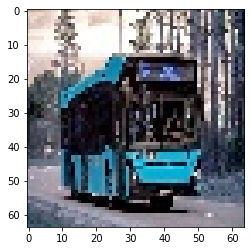

Label: 1


In [27]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = np.transpose(train_features[0].squeeze(), (1, 2,0))
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [28]:
from torch import nn

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.MaxPool2d(3, 2, 0),
            nn.ReLU(),

            nn.Conv2d(6, 12, 3),
            nn.MaxPool2d(3, 2, 0),
            nn.ReLU(),

            nn.Conv2d(12, 24, 3),
            nn.MaxPool2d(3, 2, 0),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(24, 2),

        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [31]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [32]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [48]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    wrong = []
    wrong_lb = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [37]:
epochs = 300
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn)
    #test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.655009  [    0/  588]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.650798 

Epoch 2
-------------------------------
loss: 0.661155  [    0/  588]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.651187 

Epoch 3
-------------------------------
loss: 0.678474  [    0/  588]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.639514 

Epoch 4
-------------------------------
loss: 0.631274  [    0/  588]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.641646 

Epoch 5
-------------------------------
loss: 0.661026  [    0/  588]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.649870 

Epoch 6
-------------------------------
loss: 0.674440  [    0/  588]
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.642296 

Epoch 7
-------------------------------
loss: 0.682099  [    0/  588]
Test Error: 
 Accuracy: 68.0%, Avg loss: 0.640945 

Epoch 8
-------------------------------
loss: 0.663303  [    0/  588]
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.646739 

Epoch 9
----------------

In [101]:
def test_check(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    correct_last = 0
    wrong = []

    with torch.no_grad():
        for X, y in dataloader:
            correct_last = correct
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if(correct == correct_last):
              show_image (X)
              if(y == 1):
                print('Correct: people')
              else:
                print('Correct: no_people')
                
       

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

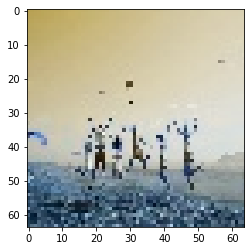

Correct: people


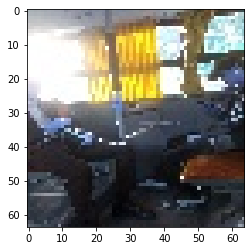

Correct: people


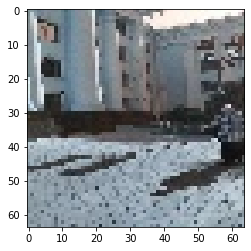

Correct: people


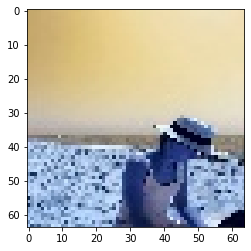

Correct: people


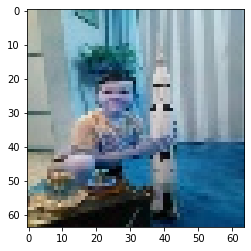

Correct: people


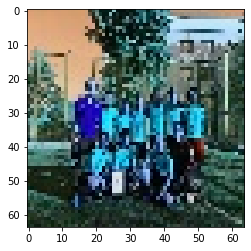

Correct: people


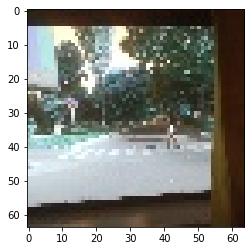

Correct: people


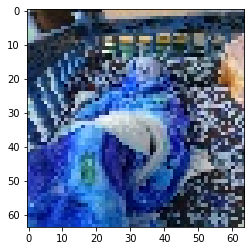

Correct: people


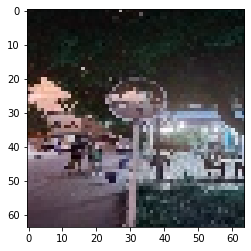

Correct: people


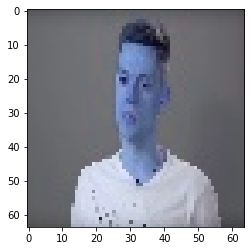

Correct: people


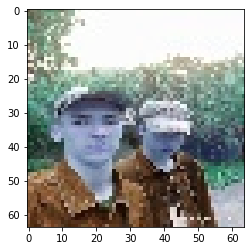

Correct: people


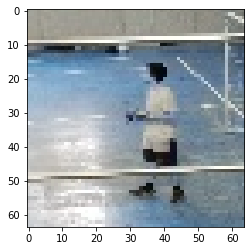

Correct: people


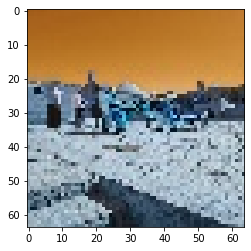

Correct: people


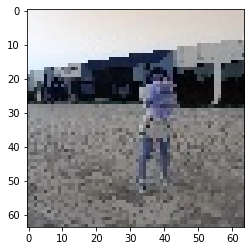

Correct: people


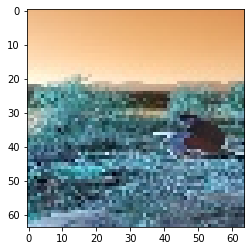

Correct: people


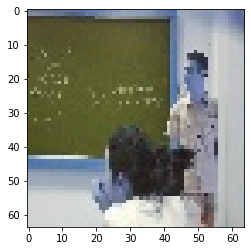

Correct: people


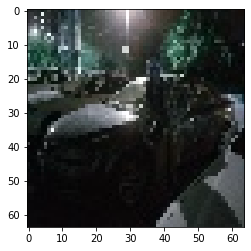

Correct: people


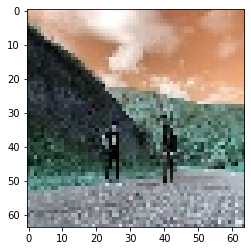

Correct: people


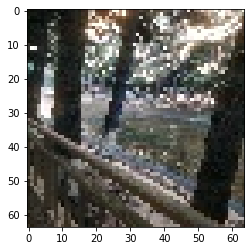

Correct: no_people


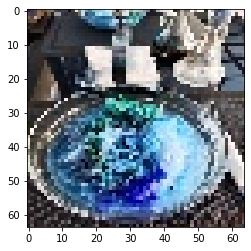

Correct: no_people


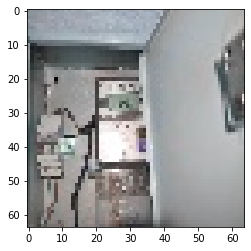

Correct: no_people


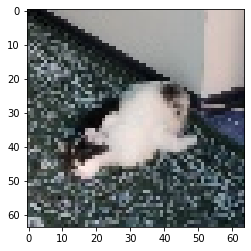

Correct: no_people


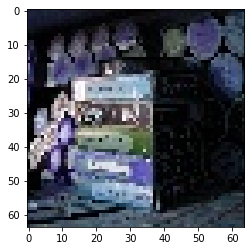

Correct: no_people


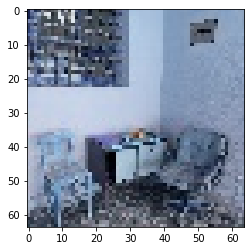

Correct: no_people


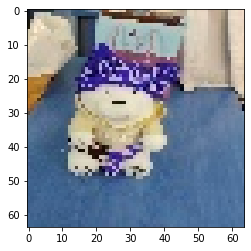

Correct: no_people


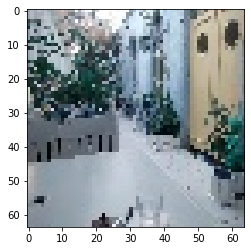

Correct: no_people


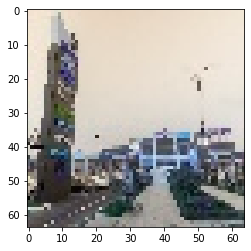

Correct: no_people


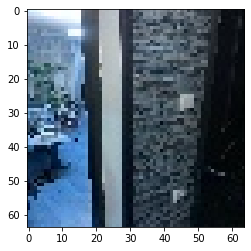

Correct: no_people


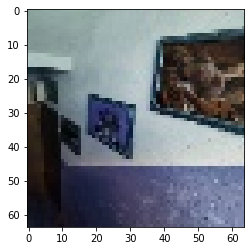

Correct: no_people


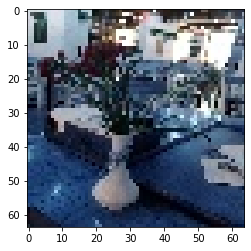

Correct: no_people


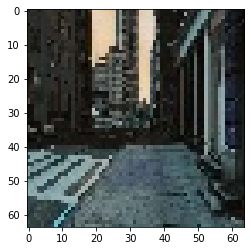

Correct: no_people


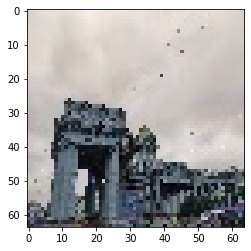

Correct: no_people


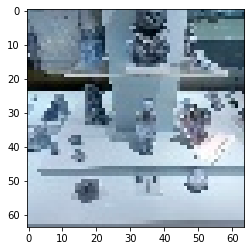

Correct: no_people


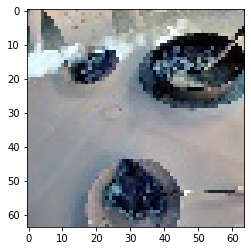

Correct: no_people


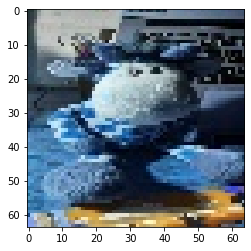

Correct: no_people


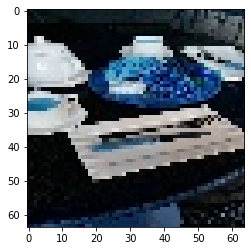

Correct: no_people


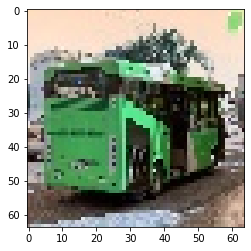

Correct: no_people


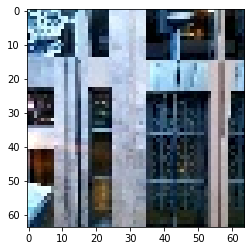

Correct: no_people


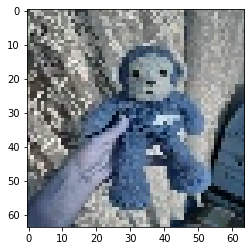

Correct: no_people
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.516124 



0.74

In [102]:
test_check(DataLoader(test_data, batch_size=1, shuffle=False), model, loss_fn)